## Kaggle Time series forecasting using Pophet

https://www.kaggle.com/manovirat/timeseries-using-prophet-hyperparameter-tuning

# 1. Why?
### * We are doing anomaly detection system for Downloads to Trials as un-expected behaviours can point out issues our user journey from downloads to trials 
### * Also product issues due to which we get trials from downloads decreased than expected

## * Our goal will be to predict our Conversion from Downloads to Trials in percentage?

## 2. How?
## * We briefly know about anomalies and what they are but in our case we wil be looking for anomalies for USA market to find contextual anomalies.
## * Hence, I have already taken a copy of data from our skidosDailyFunnel.csv file from dates 2nd July 2020 to 5th September 2021(i.e 430 days ) only for USA.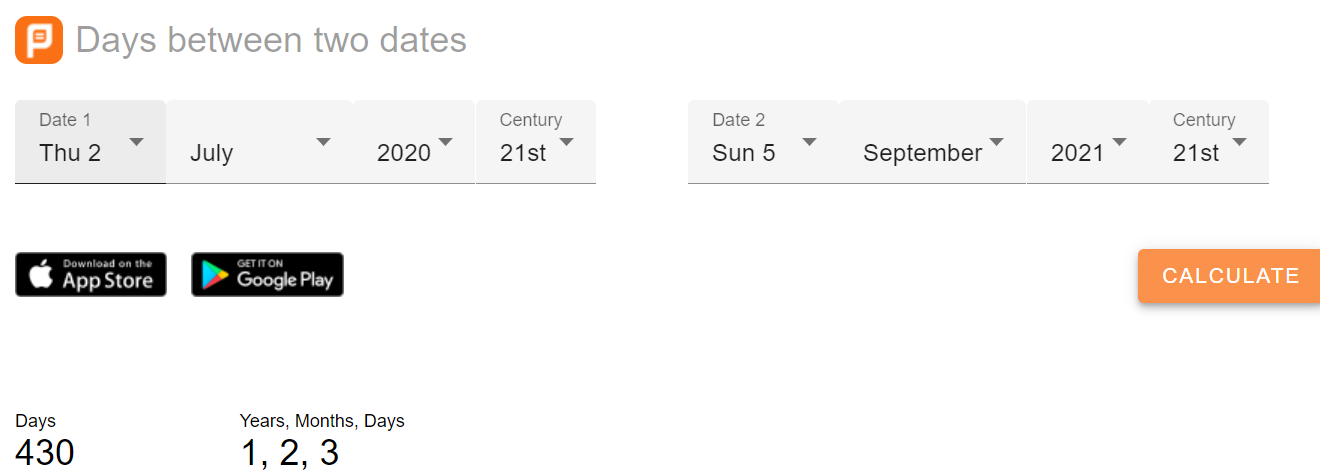

### I will be importing al the necessary libraries at the begiing itself

In [80]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# prophet by Facebook
from prophet import Prophet

import warnings
import itertools
import statsmodels.api as sm

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# visualiation
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
#plt.style.use('fivethirtyeight')



from datetime import datetime
from datetime import timedelta

# time series anlaysis and ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import register_matplotlib_converters

# visualizatoin with dates
from matplotlib import dates as mpl_dates
register_matplotlib_converters()

plt.style.use('seaborn')



## Some Necessary Custom Functions:-


In [81]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    """Function to check the data is stationary or not"""
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

In [82]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF :",dftest[0])
    print("2. P-Value :",dftest[1])
    print("3. Num of Lags :",dftest[2])
    print("4. Num of observation USed for ADF Regression and Critical Values Calculation:",dftest[3])
    print("5. Critical Values:")
    for key, val in dftest[4].items():
        print("\t",key, ": ",val)

In [83]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data

In [84]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Read the dataset

In [85]:
# will be using a date_parser to convert Dates to datetime
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv(r"D:\Data\remote file\usa_df.csv", parse_dates=['Date'], date_parser = d_parser, infer_datetime_format=True)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28623 entries, 0 to 28622
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Country             28623 non-null  object        
 1   Date                28623 non-null  datetime64[ns]
 2   Downloads           28623 non-null  float64       
 3   GameType            28623 non-null  object        
 4   Impressions         28623 non-null  float64       
 5   Name                28623 non-null  object        
 6   New Subscriptions   28623 non-null  float64       
 7   New Trials          28623 non-null  float64       
 8   Platform            28623 non-null  object        
 9   Product Page Views  28623 non-null  float64       
 10  Type                28623 non-null  object        
 11  UserId              28623 non-null  float64       
 12  ReachedLimit        28623 non-null  float64       
 13  Version             28623 non-null  float64   

In [87]:
df.set_index('Date')
#df['Date'] = pd.to_datetime(df['Date'], 
indexedDataset = df.set_index(['Date'])
print('Shape of the data filtered only for USA: ',df.shape)
#df['Year-Week'] = df['Date'].dt.strftime('%Y-%W')

#df['date'] = df.Date
df['month'] = df['Date'].dt.strftime('%B')
df['year'] = df['Date'].dt.strftime('%Y')
df['dayofweek'] = df['Date'].dt.strftime('%A')
df['quarter'] = df['Date'].dt.quarter
df['dayofyear'] = df['Date'].dt.dayofyear
df['dayofmonth'] = df['Date'].dt.day
df['weekofyear'] = df['Date'].dt.weekofyear

df  = df[['Date',
          'month',
          'year',
          'dayofweek',
          'dayofyear',
          'dayofmonth',
          'weekofyear',
          'quarter',
          'Impressions',
          'Product Page Views',
          'Platform',
          'Downloads',
          'UserId',
          'New Trials',
          'New Subscriptions',
          'ReachedLimit',
         'Re-download',
         'Free or Paid app']]


# cotextual anomaly as considering only USA
#df = df.loc[df['Country'] == 'USA']

# # aggregating on data to get sum of numeric inputs for per day
df2 = df.groupby('Date')['Impressions',
                        'Product Page Views',
                        'Downloads',
                        'UserId',
                        'New Trials',
                        'Platform',
                        'New Subscriptions',
                        'ReachedLimit',
                        'Re-download',
                        'Free or Paid app'].sum().reset_index().sort_values(by='Date')

# # # # df2['Downloads_to_Registration'] = (df2['UserId']/df2['Downloads'])*100
# # # # df2['Registration_to_New Trials'] = (df2['New Trials']/df2['UserId'])*100
# # # # df2['Monetisation_Registration'] = (df2['New Subscriptions']/df2['UserId'])* 100
# df2['Downloads_to_New_Trials'] = (df2['New Trials']/df2['Downloads'])*100
# # # df2['Monetisation_Downloads'] = (df2['New Subscriptions']/df2['Downloads'])*100


# # df2.replace([np.inf, -np.inf], np.nan, inplace=True)
# # df2.replace(np.nan, 0, inplace=True)
# # print('Shape of the data after grouping by and cleaning: ',df2.shape)
# donwloadNewTrials_df = df2[['Date', 'Downloads_to_New_Trials']]

# print("-"*60)

# print('Shape of the data to be used for Prophet forecast: ',donwloadNewTrials_df.shape)

Shape of the data filtered only for USA:  (28623, 19)


In [90]:
df.isna().any()

Date                  False
month                 False
year                  False
dayofweek             False
dayofyear             False
dayofmonth            False
weekofyear            False
quarter               False
Impressions           False
Product Page Views    False
Platform              False
Downloads             False
UserId                False
New Trials            False
New Subscriptions     False
ReachedLimit          False
Re-download            True
Free or Paid app       True
dtype: bool

In [89]:
print(df.isnull().sum())

Date                     0
month                    0
year                     0
dayofweek                0
dayofyear                0
dayofmonth               0
weekofyear               0
quarter                  0
Impressions              0
Product Page Views       0
Platform                 0
Downloads                0
UserId                   0
New Trials               0
New Subscriptions        0
ReachedLimit             0
Re-download           1079
Free or Paid app      1079
dtype: int64


iOS        22770
Android     4657
Web         1012
Unknown      184
Name: Platform, dtype: int64


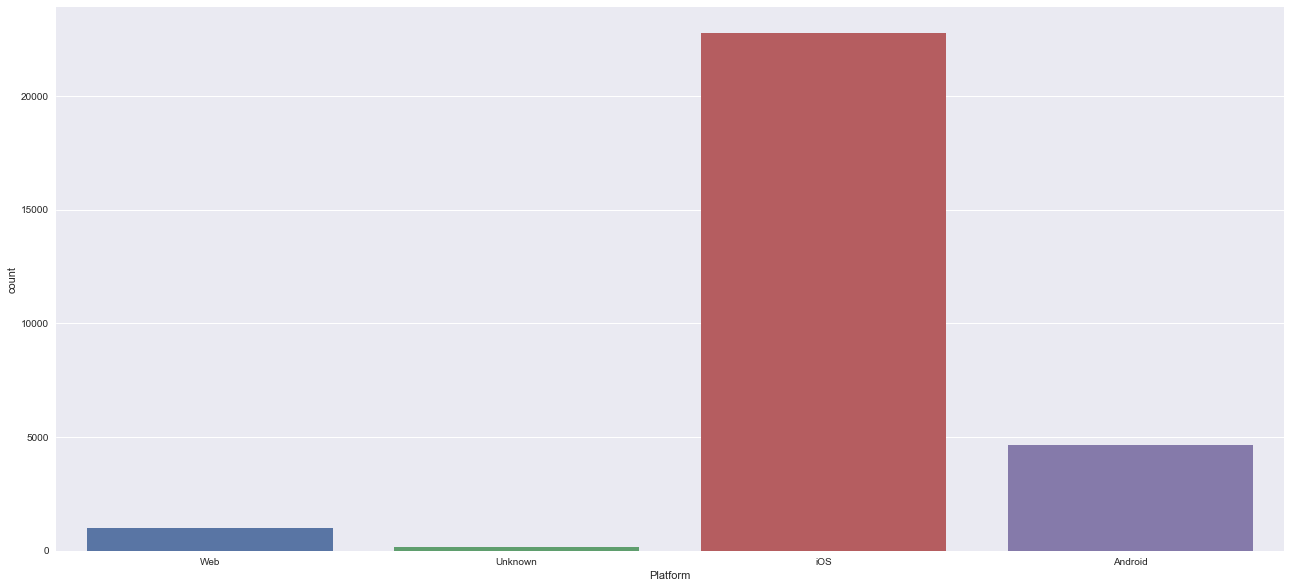

In [88]:
# Platform
print(df['Platform'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(df['Platform'])
plt.show()

In [91]:
df_new=df.copy()

In [109]:
df_new = df_new.groupby('Date')['Impressions',
                        'Product Page Views',
                        'Downloads',
                        'UserId',
                        'New Trials',
                        'Platform',
                        'New Subscriptions',
                        'ReachedLimit',
                        'Re-download',
                        'Free or Paid app'].sum().reset_index().sort_values(by='Date')

In [117]:
# df_new['Downloads_to_New_Trials'] = ((df_new['Downloads'])/(df_new['New Trials']))

In [113]:
df_new.head()

,Date,Impressions,Product Page Views,Downloads,UserId,New Trials,New Subscriptions,ReachedLimit,Re-download,Free or Paid app,Downloads_to_New_Trials
0,2020-07-02,85774.0,2313.0,1571.0,583.0,81.0,45.0,76.0,1032.0,1443.0,19.395062
1,2020-07-03,82214.0,2543.0,1485.0,541.0,81.0,53.0,78.0,1015.0,1384.0,18.333333
2,2020-07-04,74293.0,2217.0,1243.0,478.0,70.0,51.0,63.0,1161.0,1164.0,17.757143
3,2020-07-05,79744.0,2324.0,1623.0,535.0,115.0,69.0,88.0,1019.0,1511.0,14.113043
4,2020-07-06,90761.0,2893.0,1746.0,655.0,122.0,75.0,106.0,1297.0,1627.0,14.311475


In [118]:
# df_new['Downloads_to_New_Trials'].plot()

In [97]:
df_new.columns

Index(['Date', 'month', 'year', 'dayofweek', 'dayofyear', 'dayofmonth',
       'weekofyear', 'quarter', 'Impressions', 'Product Page Views',
       'Platform', 'Downloads', 'UserId', 'New Trials', 'New Subscriptions',
       'ReachedLimit', 'Re-download', 'Free or Paid app',
       'Downloads_to_New_Trials'],
      dtype='object')

In [108]:
# fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
# fig.set_size_inches(20,30)

# monthAggregated = pd.DataFrame(df_new.groupby("month")["New Subscriptions"].sum()).reset_index().sort_values('New Subscriptions')
# sns.barplot(data=monthAggregated,x="month",y="New Subscriptions",ax=ax1)
# ax1.set(xlabel='month', ylabel='New Subscriptions')
# ax1.set_title("Total Subscription By Month",fontsize=15)

Text(0.5, 1.0, 'Total New Subscriptions By year')

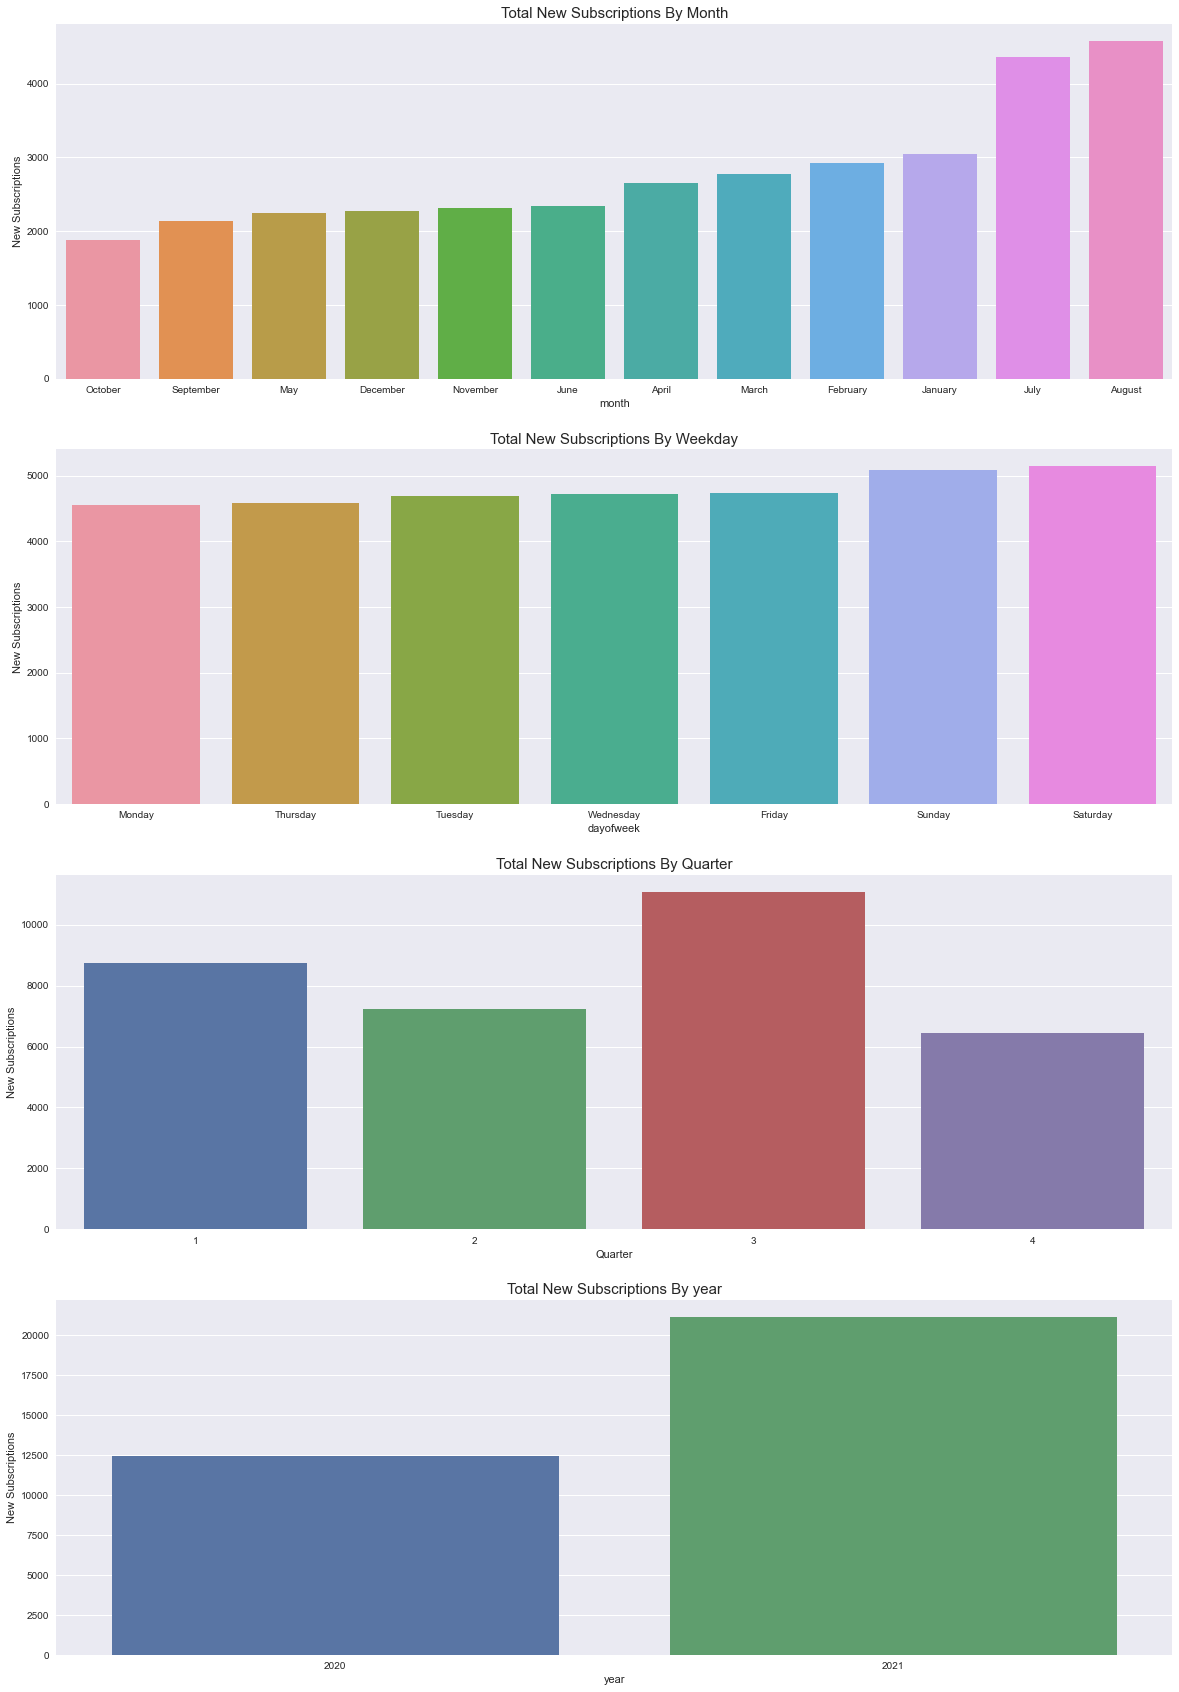

In [100]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["New Subscriptions"].sum()).reset_index().sort_values('New Subscriptions')
sns.barplot(data=monthAggregated,x="month",y="New Subscriptions",ax=ax1)
ax1.set(xlabel='month', ylabel='New Subscriptions')
ax1.set_title("Total New Subscriptions By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["New Subscriptions"].sum()).reset_index().sort_values('New Subscriptions')
sns.barplot(data=monthAggregated,x="dayofweek",y="New Subscriptions",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='New Subscriptions')
ax2.set_title("Total New Subscriptions By Weekday",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["New Subscriptions"].sum()).reset_index().sort_values('New Subscriptions')
sns.barplot(data=monthAggregated,x="quarter",y="New Subscriptions",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='New Subscriptions')
ax3.set_title("Total New Subscriptions By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["New Subscriptions"].sum()).reset_index().sort_values('New Subscriptions')
sns.barplot(data=monthAggregated,x="year",y="New Subscriptions",ax=ax4)
ax4.set(xlabel='year', ylabel='New Subscriptions')
ax4.set_title("Total New Subscriptions By year",fontsize=15)

In [105]:

# # # df2['Downloads_to_Registration'] = (df2['UserId']/df2['Downloads'])*100
# # # df2['Registration_to_New Trials'] = (df2['New Trials']/df2['UserId'])*100
# # # df2['Monetisation_Registration'] = (df2['New Subscriptions']/df2['UserId'])* 100
df2['Downloads_to_New_Trials'] = (df2['New Trials']/df2['Downloads'])*100
# # df2['Monetisation_Downloads'] = (df2['New Subscriptions']/df2['Downloads'])*100
#df2['Downloads_to_New_Trials'] = (df2['Downloads']/df2['New Trials'])*100

# df2.replace([np.inf, -np.inf], np.nan, inplace=True)
# df2.replace(np.nan, 0, inplace=True)
# print('Shape of the data after grouping by and cleaning: ',df2.shape)
donwloadNewTrials_df = df2[['Date', 'Downloads_to_New_Trials']]

print("-"*60)

print('Shape of the data to be used for Prophet forecast: ',donwloadNewTrials_df.shape)

------------------------------------------------------------
Shape of the data to be used for Prophet forecast:  (431, 2)


In [106]:
donwloadNewTrials_df.columns

Index(['Date', 'Downloads_to_New_Trials'], dtype='object')

In [107]:
donwloadNewTrials_df

,Date,Downloads_to_New_Trials
0,2020-07-02,5.155952
1,2020-07-03,5.454545
2,2020-07-04,5.631537
3,2020-07-05,7.085644
4,2020-07-06,6.987400
...,...,...
426,2021-09-01,6.678810
427,2021-09-02,5.946255
428,2021-09-03,6.662736
429,2021-09-04,6.536926


#### Divifing the data into train and test


In [68]:
# renaming coumn names to ds and y as per the requirement of prophet package implementation
donwloadNewTrials_df.rename(columns = {'Date':'ds', 'Downloads_to_New_Trials':'y'}, inplace = True)

In [69]:
donwloadNewTrials_df.columns

Index(['ds', 'y'], dtype='object')

In [70]:
end_date = '2021-07-03'
mask1 = (donwloadNewTrials_df['ds'] <= end_date)
mask2 = (donwloadNewTrials_df['ds'] > end_date)

In [71]:
X_tr = donwloadNewTrials_df.loc[mask1]
X_tst = donwloadNewTrials_df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (367, 2)
test shape (64, 2)


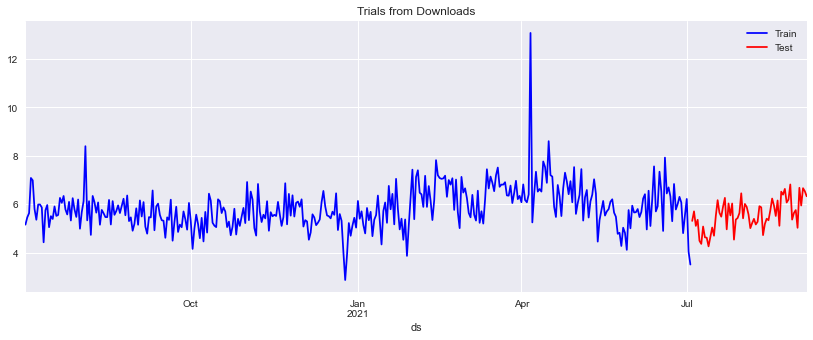

In [72]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Trials from Downloads')
plt.show()

In [73]:
test_stationarity(donwloadNewTrials_df,'y', signif=0.05, series=False)

'Stationary'

In [119]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# donwloadNewTrials_df['y'].plot(figsize=(15,8), linewidth=3)
# plt.show()

In [74]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_tr)

In [75]:
future = final_model.make_future_dataframe(periods=60, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
417,2021-08-23,4.329962,3.038271,5.595862
418,2021-08-24,4.554627,3.190700,5.912032
419,2021-08-25,4.310521,3.019386,5.700106
420,2021-08-26,4.198297,2.847691,5.506038
421,2021-08-27,4.260662,2.899913,5.615577
422,2021-08-28,4.322651,2.987668,5.775666
423,2021-08-29,4.540645,3.181585,5.774027
424,2021-08-30,4.339506,3.100318,5.617622
425,2021-08-31,4.567054,3.278079,5.941041
426,2021-09-01,4.326065,3.042395,5.694275


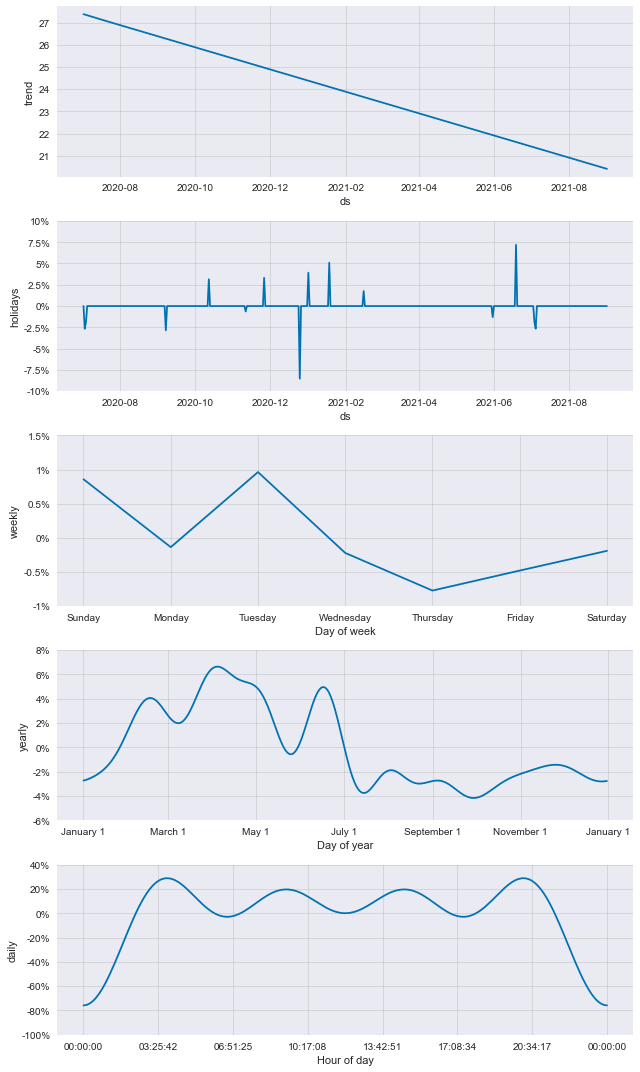

In [76]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

In [15]:
model =Prophet()
model.fit(X_tr)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Now we will be making future dataframe with future dates
## *  As I have taken 2021-07-31 to be the end date
## * Will try predicting values for next two months


In [16]:
future = model.make_future_dataframe(periods=60, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
435,2021-09-10,4.671126,3.588350,5.719958
436,2021-09-11,4.825691,3.850209,5.863198
437,2021-09-12,5.022827,4.003489,5.967968
438,2021-09-13,4.812280,3.826221,5.859120
439,2021-09-14,4.978300,4.062188,5.955018
440,2021-09-15,4.724735,3.719570,5.687910
441,2021-09-16,4.617378,3.631093,5.636874
442,2021-09-17,4.595266,3.623678,5.605202
443,2021-09-18,4.749831,3.753257,5.763336
444,2021-09-19,4.946967,3.910072,6.008206


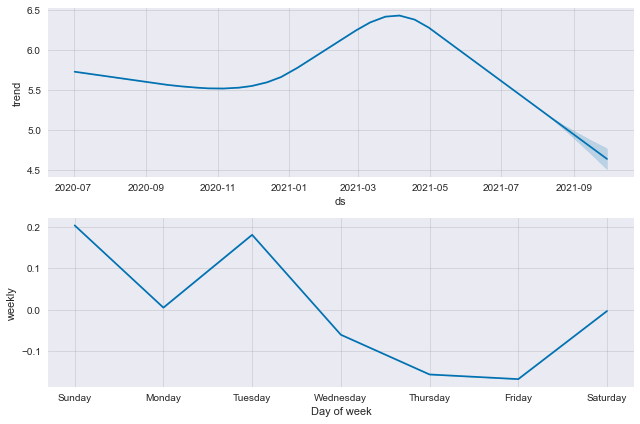

In [17]:
# Plot the components of the model
fig = model.plot_components(forecast)

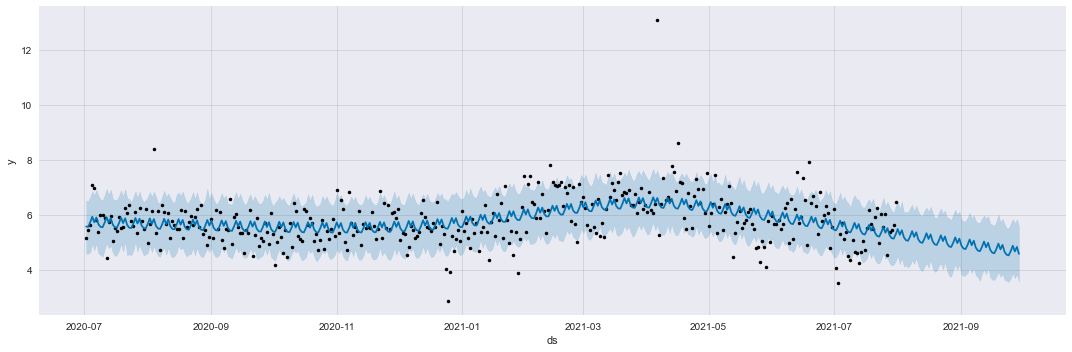

In [18]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

In [19]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
26,2021-08-27,4.822845,3.833343,5.855038
27,2021-08-28,4.977411,3.955629,5.993528
28,2021-08-29,5.174546,4.190172,6.161873
29,2021-08-30,4.964000,3.985530,5.926215
30,2021-08-31,5.130019,4.177266,6.122335
31,2021-09-01,4.876454,3.856414,5.849057
32,2021-09-02,4.769097,3.778130,5.763931
33,2021-09-03,4.746986,3.745868,5.737990
34,2021-09-04,4.901551,3.880387,5.876091
35,2021-09-05,5.098686,4.100900,6.117622


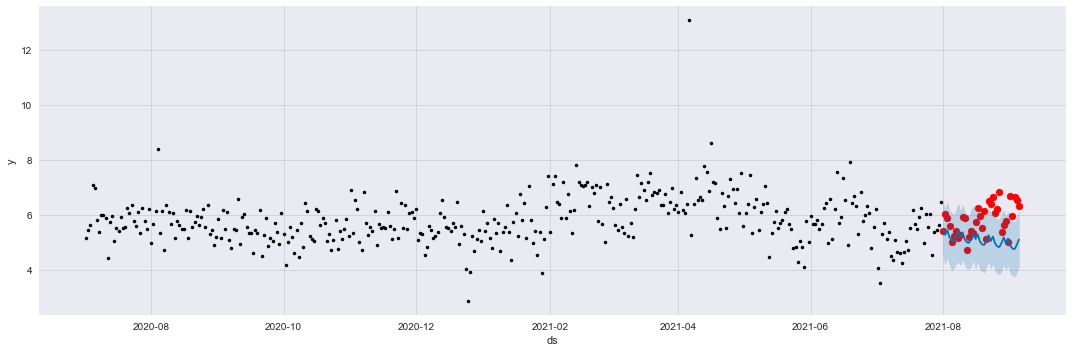

In [20]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

## Comparing the trials from downloads actual with predicted

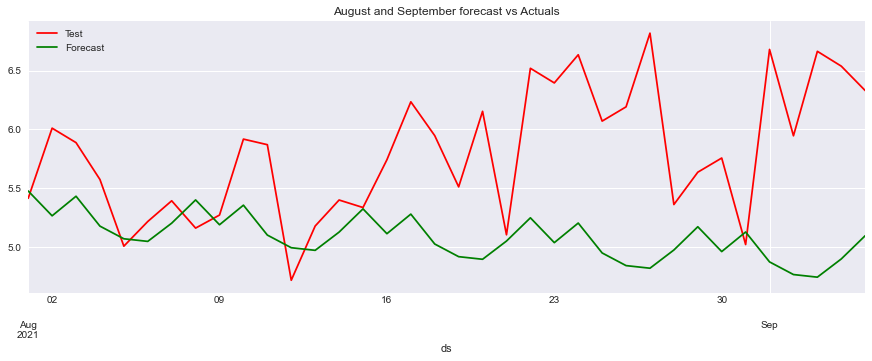

In [21]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('August and September forecast vs Actuals')
plt.show()

We can see from the above plot, that there is huge gap in prediction. So we need to optimize the model by adding other parameters like holidays, changepoints etc.

In [120]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
count = 0
for p in grid:
    count = count+1

print('Total Possible Models',count)

Total Possible Models 150


In [ ]:
mape = []
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    mape.appen(MAPE)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=60, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)

ConversionError: Failed to convert value(s) to axis units: '2020-07-01'

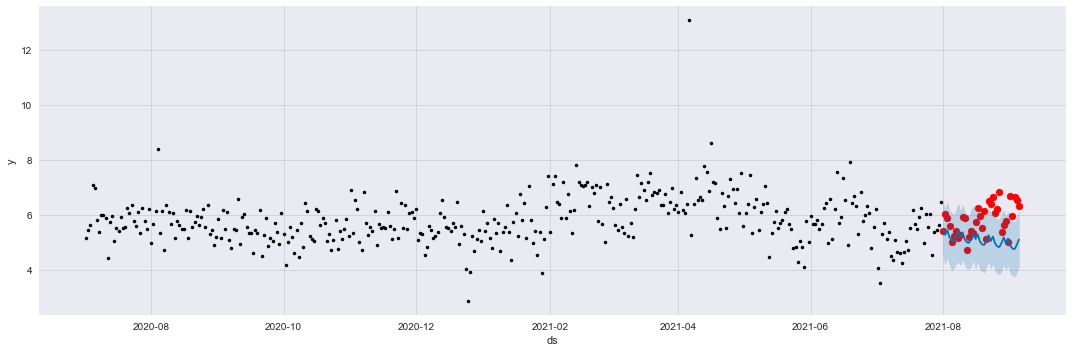

In [22]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)
ax.set_xbound(lower='2020-07-01', upper='2020-07-08')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of July vs Actuals')

In [23]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 12.1352


### As observe our predictions are not close hence we are gonna add few in built feature from Prophet to improve the model


In [26]:
import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2020,2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holiday"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday
0,2020-01-01,US-Holiday
1,2020-01-20,US-Holiday
2,2020-02-17,US-Holiday
3,2020-05-25,US-Holiday
4,2020-07-03,US-Holiday


## Setting up the model with us holidays

In [28]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(X_tr)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
future = model_with_holidays.make_future_dataframe(periods=57, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
442,2021-09-17,4.599790,3.670938,5.590223
443,2021-09-18,4.756037,3.773763,5.774056
444,2021-09-19,4.954862,3.932117,5.950197
445,2021-09-20,4.736006,3.702386,5.734899
446,2021-09-21,4.912205,3.880864,5.999145
447,2021-09-22,4.657096,3.617689,5.650616
448,2021-09-23,4.550270,3.537428,5.591116
449,2021-09-24,4.525021,3.559840,5.520989
450,2021-09-25,4.681267,3.721426,5.690203
451,2021-09-26,4.880093,3.824134,5.793286


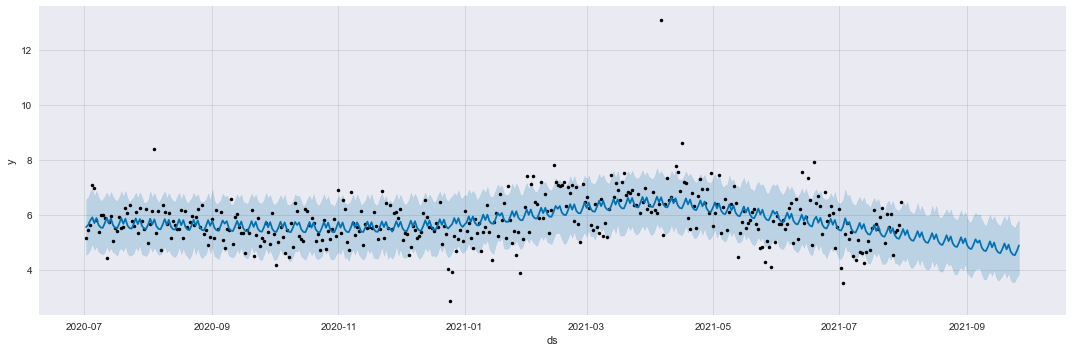

In [30]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

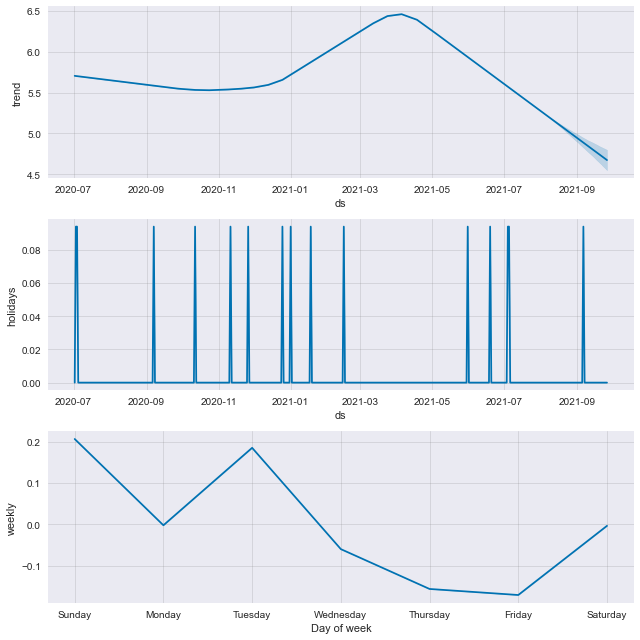

In [31]:
# Plot the components of the model
fig = model_with_holidays.plot_components(forecast)

In [34]:
X_tst_forecast_holiday = model_with_holidays.predict(X_tst)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
26,2021-08-27,4.824097,3.784903,5.804438
27,2021-08-28,4.980344,3.959505,5.894296
28,2021-08-29,5.179169,4.142321,6.180348
29,2021-08-30,4.960313,4.109416,5.939011
30,2021-08-31,5.136513,4.193845,6.189568
31,2021-09-01,4.881403,3.819790,5.880807
32,2021-09-02,4.774577,3.930344,5.746262
33,2021-09-03,4.749328,3.701942,5.655345
34,2021-09-04,4.905575,3.980145,5.816677
35,2021-09-05,5.104400,4.117767,6.047190


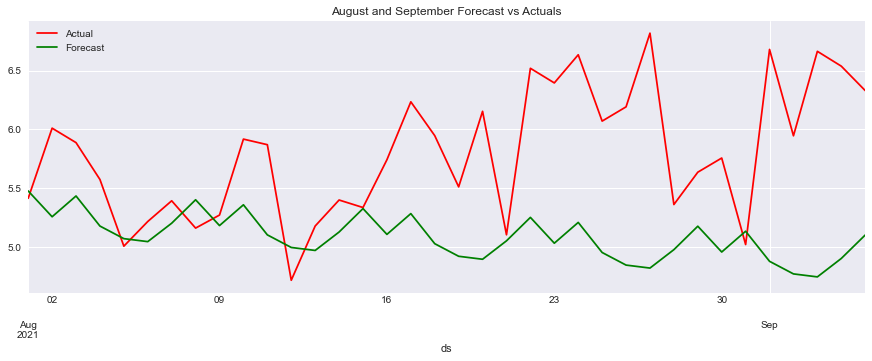

In [35]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('August and September Forecast vs Actuals')
plt.show()

In [36]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast_holiday['yhat'])
print("MAPE",round(mape,4))

MAPE 12.1246


From the above results, we can see that by adding holidays in the model, model performance further reduced. We need to add other parameters to tune the model.

Along with holidays, there are many other hyperparameters which helps in optimizing the prophet model.

Holidays
Changepoints: (n_changepoints,changepoint_prior_scale)
seasonality_mode
holiday_prior_scale
Seasonalities with fourier_order
We have added holidays to our model and saw its effect.

n_changepoints is the number of change happen in the data. Prophet model detects them by its own. By default, its value is 25, which are uniformly placed in the first 80% of the time series. Changing n_changepoints can add value to the model.

changepoint_prior_scale to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If you make it high it will be more flexible, but you can end up overfitting. By default, this parameter is set to 0.05

seasonality_mode There are 2 types model seasonality mode. Additive & multiplicaticative. By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the model.

holiday_prior_scale just like changepoint_prior_scale, holiday_prior_scale is used to smoothning the effect of holidays. By default its value is 10, which provides very little regularization. Reducing this parameter dampens holiday effects

Seasonalities with fourier_order Prophet model, by default finds the seasonalities and adds the default parameters of the seasonality. We can modify the seasonalities effect by adding custom seasonalities as add_seasonality in the model with different fourier order.Yy default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.

Now, we will do the hyperparameters tuning using parametergrid. parametergrid will create all the possible parameters combination and will test the model prediction using every combination. I am taking 4 parameters: n_changepoints, changepoint_prior_scale,seasonality_mode, holiday_prior_scale for tuning.

# HyperParameter Tuning using ParameterGrid

In [37]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
count = 0
for p in grid:
    count = count+1

print('Total Possible Models',count)

Total Possible Models 150


# Prophet Model Tuning

In [42]:
import random 
strt='2020-07-02'
end='2021-07-31'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=60, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
#     #test=train_forecast[['ds','yhat']]
#     Actual = df[(df['ds']>strt) & (df['ds']<=end)]
#     MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
#     print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
#     model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.1, 'holida

{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.3, 'holida

{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.5, 'holida

In [43]:
test=train_forecast[['ds','yhat']]
Actual = df[(df['ds']>strt) & (df['ds']<=end)]
MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

KeyError: 'ds'

In [44]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters


In [45]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_tr)

In [46]:
future = final_model.make_future_dataframe(periods=60, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)


,ds,yhat,yhat_lower,yhat_upper
445,2021-09-20,4.839814,3.587893,6.180370
446,2021-09-21,5.011182,3.641972,6.352118
447,2021-09-22,4.763903,3.383133,6.163245
448,2021-09-23,4.635405,3.370822,6.004763
449,2021-09-24,4.638291,3.333557,5.847298
450,2021-09-25,4.738906,3.423994,6.051281
451,2021-09-26,4.952104,3.661568,6.259196
452,2021-09-27,4.729298,3.518455,6.045902
453,2021-09-28,4.915679,3.591295,6.337742
454,2021-09-29,4.685031,3.351646,6.113038


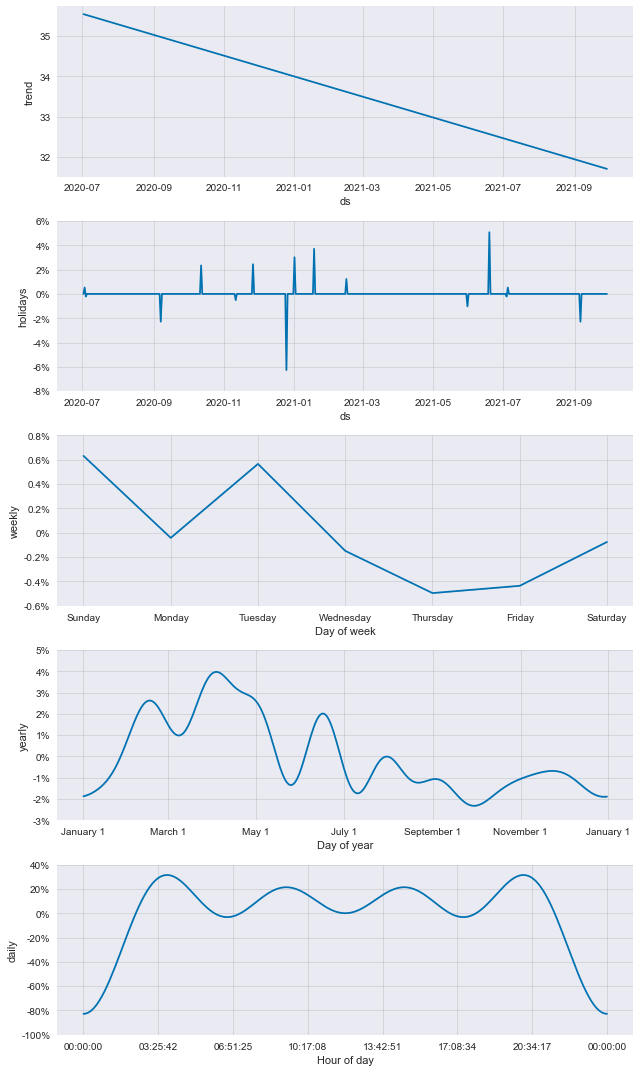

In [47]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

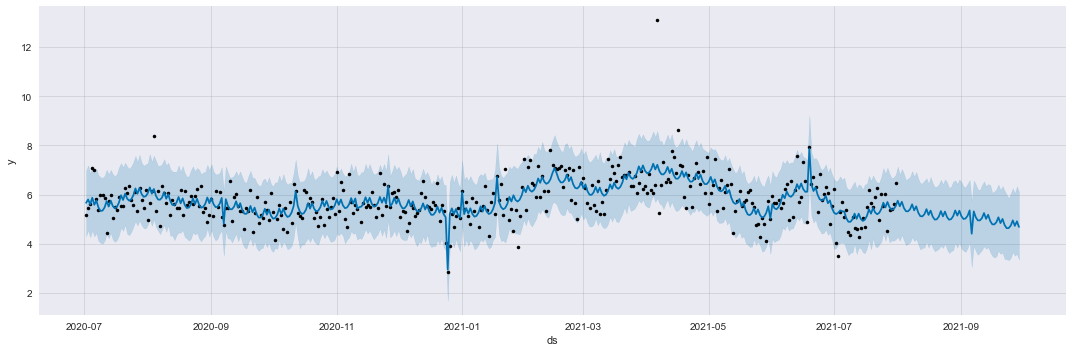

In [48]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [53]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

NameError: name 'X_tst_final' is not defined

NameError: name 'X_tst_final' is not defined

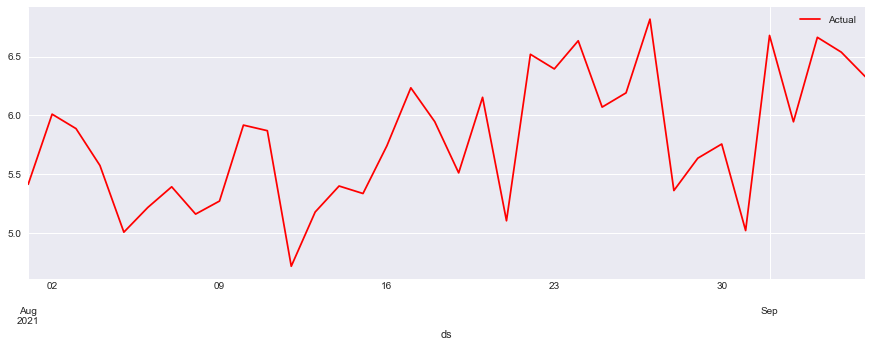

In [50]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('August and September Forecast vs Actuals')
plt.show()

In [ ]:
country_holiday='USA'

In [ ]:
def date_features(df, label=None):
    df = df.copy()

    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(donwloadNewTrials_df, label='Downloads_to_New_Trials')
df_new = pd.concat([X, y], axis=1)
#df_new.head()

In [ ]:
df_new

In [ ]:
df_new['Downloads_to_New_Trials'].max()

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Downloads_to_New_Trials",hue = 'year',data=df_new)
a.set_title("a",fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [ ]:
df_new.tail(30)

In [ ]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["Downloads_to_New_Trials"].sum()).reset_index().sort_values('Downloads_to_New_Trials')
sns.barplot(data=monthAggregated,x="month",y="Downloads_to_New_Trials",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales received')
ax1.set_title("Total Sales received By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["Downloads_to_New_Trials"].sum()).reset_index().sort_values('Downloads_to_New_Trials')
sns.barplot(data=monthAggregated,x="dayofweek",y="Downloads_to_New_Trials",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total Sales received')
ax2.set_title("Total Sales received By Weekday",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["Downloads_to_New_Trials"].sum()).reset_index().sort_values('Downloads_to_New_Trials')
sns.barplot(data=monthAggregated,x="quarter",y="Downloads_to_New_Trials",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total Sales received')
ax3.set_title("Total Sales received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["Downloads_to_New_Trials"].sum()).reset_index().sort_values('Downloads_to_New_Trials')
sns.barplot(data=monthAggregated,x="year",y="Downloads_to_New_Trials",ax=ax4)
ax4.set(xlabel='year', ylabel='Total Sales received')
ax4.set_title("Total Sales received By year",fontsize=15)


In [ ]:
# this a snippet from Kaggle tyring this out 
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

# df1 = df.groupby('Date')['Downloads',
#                         'UserId',
#                         'New Trials',
#                         'New Subscriptions'].sum().reset_index().sort_values(by='Date')

# df1['Downloads_to_New_Trials'] = (df2['New Trials']/df2['Downloads'])*100
# # # df2['Monetisation_Downloads'] = (df2['New Subscriptions']/df2['Downloads'])*100

# df1.replace([np.inf, -np.inf], np.nan, inplace=True)
# df1.replace(np.nan, 0, inplace=True)

df3 = df.groupby('Month')['Downloads',
                        'UserId',
                        'New Trials',
                        'New Subscriptions'].sum().reset_index().sort_values(by='Month')

df3['Downloads_to_New_Trials'] = (df2['New Trials']/df2['Downloads'])*100

df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df3.replace(np.nan, 0, inplace=True)


sns.barplot(data=df3,x="month",y="Downloads_to_New_Trials",ax=ax1)
ax1.set(xlabel='Month', ylabel='Conversion of Trials from downloads')
ax1.set_title("Conversion of Trials from downloads By Month",fontsize=15)

# df3 = df.groupby('dayofweek')['Downloads',
#                         'UserId',
#                         'New Trials',
#                         'New Subscriptions'].sum().reset_index().sort_values(by='dayofweek')

# df3['Downloads_to_New_Trials'] = (df2['New Trials']/df2['Downloads'])*100

# df3.replace([np.inf, -np.inf], np.nan, inplace=True)
# df3.replace(np.nan, 0, inplace=True)

# sns.barplot(data=df3,x="month",y="Downloads_to_New_Trials",ax=ax1)
# ax1.set(xlabel='Month', ylabel='Conversion of Trials from downloads')
# ax1.set_title("Conversion of Trials from downloads By Month",fontsize=15)


# sns.barplot(data=df3,x="dayofweek",y="Downloads_To_Trials_dayofweek",ax=ax2)
# ax2.set(xlabel='dayofweek', ylabel='Conversion of Trials from downloads')
# ax2.set_title("Conversion of Trials from downloads By Weekday",fontsize=15)

# monthAggregated = pd.DataFrame(df.groupby("quarter")['Downloads',
#           'UserId',
#           'New Trials',
#           'New Subscriptions'].sum()).reset_index().sort_values('New Trials')
# monthAggregated['Downloads_To_Trials_quarter']
# sns.barplot(data=monthAggregated,x="quarter",y="Downloads_To_Trials_quarter",ax=ax3)
# ax3.set(xlabel='Quarter', ylabel='Conversion of Trials from downloads')
# ax3.set_title("Conversion of Trials from downloads By Quarter",fontsize=15)

# monthAggregated = pd.DataFrame(df.groupby("year")['Downloads',
#           'UserId',
#           'New Trials',
#           'New Subscriptions'].sum()).reset_index().sort_values('New Trials')
# monthAggregated['Downloads_To_Trials_year']
# sns.barplot(data=monthAggregated,x="year",y="Downloads_To_Trials_year",ax=ax4)
# ax4.set(xlabel='year', ylabel='Conversion of Trials from downloads')
# ax4.set_title("Conversion of Trials from downloads By Year",fontsize=15)

In [ ]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

# Montly anlalyis from trials from downloads by Month
df3 = pd.DataFrame(df.groupby("month")['Downloads',
                        'UserId',
                        'New Trials',
                        'New Subscriptions'].sum()).reset_index().sort_values('month')
df3['Downloads_to_New_Trials'] = (df['New Trials']/df['Downloads'])*100

df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df3.replace(np.nan, 0, inplace=True)

# -------------------------------#
# vusalization of downloadstotrial 
sns.barplot(data=monthAggregated,x="month",y="Downloads_to_New_Trials",ax=ax1)
ax1.set(xlabel='Month', ylabel='Percenteage Trials from Downloads Completed')
ax1.set_title("Total Trials from Downloads By Month",fontsize=15)

# # Weekly Analysis of trials from downloads by day of week
# df4 = pd.DataFrame(df.groupby("dayofweek")['Downloads',
#                         'UserId',
#                         'New Trials',
#                         'New Subscriptions'].sum()).reset_index().sort_values('dayofweek')
# df4['dayofweekAggregatted'] = (df['New Trials']/df['Downloads'])*100

# df4.replace([np.inf, -np.inf], np.nan, inplace=True)
# df4.replace(np.nan, 0, inplace=True)
# ---------------------------------#
# Visuailization fo downloadstotrials with dayofweek
# sns.barplot(data=dayofweekAggregated,x="dayofweek",y="Downloads_to_New_Trials",ax=ax2)
# ax2.set(xlabel='dayofweek', ylabel='Prcentage of Trials from Downloads completed')
# ax2.set_title("Total Tials from Downloads by DayofWeek",fontsize=15)

# Quartely Analysis of trials from downloads by quarter
# df5 = pd.DataFrame(df.groupby("quarter")['Downloads',
#                         'UserId',
#                         'New Trials',
#                         'New Subscriptions'].sum()).reset_index().sort_values('quarter')
# df5['quartedAggregted'] = (df['New Trials']/df['Downloads'])*100

# df2.replace([np.inf, -np.inf], np.nan, inplace=True)
# df2.replace(np.nan, 0, inplace=True)
# # -------------------------#
# # visualization of downloadstotrials over quarter
# sns.barplot(data=quarterAggregated,x="quarter",y="Downloads_to_New_Trials",ax=ax3)
# ax3.set(xlabel='Quarter', ylabel='Trials From Downloads')
# ax3.set_title("Total Trials from Downloads By Quarter",fontsize=15)

# Yearly Analysis for trials from downloads by year
# df6 = pd.DataFrame(df.groupby("year")['Downloads',
#                         'UserId',
#                         'New Trials',
#                         'New Subscriptions'].sum()).reset_index().sort_values('Downloads')

# df6['Downloads_to_New_Trials'] = (df['New Trials']/df['Downloads'])*100

# df2.replace([np.inf, -np.inf], np.nan, inplace=True)
# df2.replace(np.nan, 0, inplace=True)
# # -------------------------#
# # Visualization of downloadstotrials over year

# sns.barplot(data=yearAggregated,x="year",y="Downloads_to_New_Trials",ax=ax4)
# ax4.set(xlabel='year', ylabel='Tails from Dowloads')
# ax4.set_title("Total Tials from Downloads By Year",fontsize=15)

# Checkin the shape of individual df
print("Shape of Grouped Monthly:", df3.shape)
# print("Shape of Grouped DayofWeek:", df4.shape)
# print("Shape of the Grouped quarter:", df5.shape)
# print("Shape of the Grouped Yearly:", df6.shape)

In [ ]:
indexedDataset = df.set_index(['Date'])
print('Shape of the data: ',df.shape)

In [ ]:
print('-'*60)
print('*** Head of the dataframe ***')
print('-'*60)
print(df.head())
print('-'*60)
print('*** Tail of the dataframe ***')
print('-'*60)
print(df.tail())

In [ ]:
# df=df.rename(columns={'Date':'ds','Downloads':'y'})
# df.head()

In [ ]:
# renaming coumn names to ds and y as per the requirement of prophet package implementation
downloads.rename(columns = {'Date':'ds', 'Downloads':'y'}, inplace = True)
print(downloads['y'].max())
print(downloads['y'].min())

In [ ]:
## Plot the Time series data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="Date", y="Sales", data=df)
a.set_title("DownloadsToTrials",fontsize=15)
plt.show()